In [1]:
import numpy as np
import matplotlib.pyplot as plt

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct

In [2]:
from UserClass import *
from basic_environments import *
from basic_learners import *

In [7]:
%run DATA_users.py
%run DATA_parameters.py

# Step 5

### Environment

In [4]:
class NS_Environment:
    def __init__(self, prices, cost, n_daily_clicks, cum_daily_costs, user_class, horizon):
        
        self.userclass = user_class
        self.cost = cost        
        self.prices = prices    
        
        self.pricing_environment = PricingEnvironment(prices, cost, user_class)

        self.n_daily_clicks = max(int(n_daily_clicks), 0)
        self.cum_daily_costs = cum_daily_costs
        self.n_phases = len(user_class.conversion_rate_function(prices))
        self.conversion_probabilities = []
        for i in range(0, self.n_phases):
            self.conversion_probabilities.append([user_class.conversion_rate_function(p)[i] for p in prices])
        self.t = 0
        self.horizon = horizon
        self.phase_size = self.horizon/self.n_phases
        """ 
        here the 3 phases occur just once during the horizon (as seen in lectures).
        another option is to pass the lenght of the phases 
        """

    def round(self, pulled_arm):
        current_phase = int((self.t - self.horizon*int(self.t / self.horizon)) / self.phase_size)
        #p = self.conversion_probabilities[current_phase][pulled_arm]
        self.t += 1
        reward = self.pricing_environment.round(pulled_arm, self.n_daily_clicks, self.cum_daily_costs)[current_phase]
        return reward

### Sliding Window UCB1

In [37]:
class SW_UCB1_Learner(Learner):
    def __init__(self, n_arms, window_size, support = (0,1)):
       
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)
        self.c = (support[1] - support[0]) * np.sqrt(2)

        self.window_size = window_size 
        self.pulled_arms = np.array([])

    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        

        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

        #-update confidences and means
        for a in range(self.n_arms):
            discount = np.array([])
            pull_history = self.pulled_arms[-self.window_size:] == a
            n_samples = np.sum(pull_history)
            for s in range(np.max([self.t - self.window_size + 1, 1]), self.t+1):
                discount = np.append(discount, np.power(0.99, self.t-s))
            n_samples_d = np.sum(discount*pull_history)                      #n_samples = np.sum(self.pulled_arms[-self.window_size:] == a)
            cum_rew = np.sum(self.rewards_per_arm[a][-n_samples:]) if n_samples > 0 else 0
            if n_samples > 0:
                self.empirical_means[a] = cum_rew / n_samples_d
                self.confidence[a] = self.c * np.sqrt(np.log(np.min([self.t, self.window_size]))/n_samples_d)
            else:
                self.empirical_means[a] = 0
                self.confidence[a] = np.inf
            #print('time: ' + str(self.t) + ', arm: ' + str(a) + ', nsamples: ' + str(n_samples_d) + '  ' + str(n_samples) + ', cumrew: ' + str(cum_rew) + ', emp mean: ' + str(self.empirical_means[a]) + ', conf: ' + str(self.empirical_means[a] + self.confidence[a]))
        #print('\n\n')
        self.update_observations(pulled_arm, reward)



In [26]:
class SW_UCB1_Learner(Learner):
    def __init__(self, n_arms, window_size, support = (0,1)):
       
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)
        self.c = (support[1] - support[0]) * np.sqrt(2)

        self.window_size = window_size 
        self.pulled_arms = np.array([])

    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)
        for arm in range(self.n_arms):
            n_samples = np.sum(self.pulled_arms[-self.window_size:] == arm)
            cum_rew = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
            self.empirical_means[arm] = cum_rew / n_samples
        #-update confidences and means\n",
        for a in range(self.n_arms):
            n_samples = np.sum(self.pulled_arms[-self.window_size:] == a)
            cum_rew = np.sum(self.rewards_per_arm[a][-n_samples:]) if n_samples > 0 else 0
            if n_samples > 0:
                self.confidence[arm] = self.c * np.sqrt(np.log(self.window_size)/n_samples)
                self.empirical_means[a] = cum_rew / n_samples
                self.confidence[a] = self.c * np.sqrt(np.log(self.window_size)/n_samples)
            else:
                self.confidence[arm] = np.inf
                self.empirical_means[a] = 0
                self.confidence[a] = np.inf
        self.update_observations(pulled_arm, reward)

In [38]:
class Custom_SW_UCB_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, window_size, M=1):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs

        self.conversion_rate_learner = SW_UCB1_Learner(n_arms, window_size, support=(0,M))


    def pull_arm(self):
        idx_arm = self.conversion_rate_learner.pull_arm()
        return idx_arm


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks)
        self.conversion_rate_learner.update(pulled_arm, alpha)

## Example

Parameters

In [22]:
# Training parameters
T = 365
n_experiments = 1000
window_size = 4*int(np.sqrt(T))

BID_STEP1 = BIDS[55]

Clairvoyant

In [12]:
n_daily_clicks = int(C1_NS.n_daily_clicks_function(BID_STEP1))
cum_daily_costs = C1_NS.cum_daily_costs_function(BID_STEP1)

opt_value1 = np.max(C1_NS.conversion_rate_function(PRICES)[0] * (PRICES - MARGIN_PARAM))
opt_value2 = np.max(C1_NS.conversion_rate_function(PRICES)[1] * (PRICES - MARGIN_PARAM))
opt_value3 = np.max(C1_NS.conversion_rate_function(PRICES)[2] * (PRICES - MARGIN_PARAM))

opt1 = n_daily_clicks * opt_value1 - cum_daily_costs
opt2 = n_daily_clicks * opt_value2 - cum_daily_costs
opt3 = n_daily_clicks * opt_value3 - cum_daily_costs

opt_arm1 = np.argmax(C1_NS.conversion_rate_function(PRICES)[0] * (PRICES - MARGIN_PARAM))
opt_arm2 = np.argmax(C1_NS.conversion_rate_function(PRICES)[1] * (PRICES - MARGIN_PARAM))
opt_arm3 = np.argmax(C1_NS.conversion_rate_function(PRICES)[2] * (PRICES - MARGIN_PARAM))

print("n_daily_clicks: ", n_daily_clicks)
print("cum_daily_costs: ", cum_daily_costs)
print()
print("optimal price phase 1: ", PRICES[opt_arm1])
print("optimal price phase 2: ", PRICES[opt_arm2])
print("optimal price phase 3: ", PRICES[opt_arm3])
print("conversion rate on the optimal price phase 1: ", C1.conversion_rate_function(PRICES[opt_arm1]))
print("conversion rate on the optimal price phase 2: ", C1.conversion_rate_function(PRICES[opt_arm2]))
print("conversion rate on the optimal price phase 3: ", C1.conversion_rate_function(PRICES[opt_arm3]))
print("optimal reward phase 1: ", opt1)
print("optimal reward phase 2: ", opt2)
print("optimal reward phase 3: ", opt3)

n_daily_clicks:  100
cum_daily_costs:  360.0

optimal price phase 1:  50
optimal price phase 2:  80
optimal price phase 3:  50
conversion rate on the optimal price phase 1:  0.9
conversion rate on the optimal price phase 2:  0.20081714413358684
conversion rate on the optimal price phase 3:  0.9
optimal reward phase 1:  540.0
optimal reward phase 2:  3052.5
optimal reward phase 3:  540.0


### Running algorithm

In [44]:
## SW_UCB learner

sw_ucb_rewards_per_experiment = []

sw_ucb_conversion_rate_hat = np.zeros(len(PRICES))
sw_ucb_conversion_rate_bound = np.zeros(len(PRICES))

for e in range(0, n_experiments):
    if e%(int(n_experiments/10)) == 0:
        print(f'{e/n_experiments*100}%')
    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS, T)
    sw_ucb_learner = Custom_SW_UCB_Learner(PRICES, n_daily_clicks, cum_daily_costs, window_size, M=12)

    for t in range(0, T):
        pulled_arm = sw_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        sw_ucb_learner.update(pulled_arm, reward)
        
    sw_ucb_rewards_per_experiment.append(sw_ucb_learner.collected_rewards)

    sw_ucb_conversion_rate_hat += sw_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    sw_ucb_conversion_rate_bound += sw_ucb_learner.conversion_rate_learner.confidence/n_experiments

sw_ucb_std_inst = np.std(sw_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
sw_ucb_std_cum = np.std(np.cumsum(sw_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

sw_ucb_mean_rewards_hat = np.mean(sw_ucb_rewards_per_experiment, axis = 0)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


### Plots

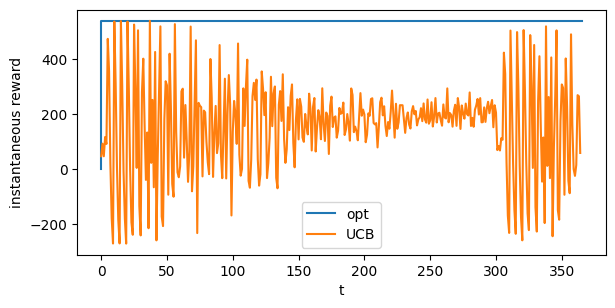

In [36]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.step([0, 122, 244, 365],[0, opt1, opt2, opt3], where='pre', label = "opt")
plt.plot(sw_ucb_mean_rewards_hat, color = 'C1', label = "UCB")
#plt.fill_between(np.arange(T), sw_ucb_mean_rewards_hat - sw_ucb_std_inst, sw_ucb_mean_rewards_hat + sw_ucb_std_inst, alpha = 0.2, color = 'C1')
plt.legend()

### CUSUM UCB

In [91]:
#CHANGE DETECTION UCB

class CUSUM_UCB1_Learner(Learner):
    def __init__(self, n_arms, support = (0,12)):
        """
        support: tuple
            the support interval of what we are learning
            e.g. in the case we are learning a probability p -> support = (0,1)
        """
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)
        self.c = (support[1] - support[0]) * np.sqrt(2)
        self.p_detections = []
        self.m_detections = []
        self.gp = np.zeros(n_arms)
        self.gm = np.zeros(n_arms)
        self.sp = np.zeros(n_arms)
        self.sm = np.zeros(n_arms)
        self.epsilon = 5
        self.h = 50
        self.M = np.zeros(n_arms)
        self.gpchart = []
        self.gmchart = []
        self.index = 0

    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.index += 1
        self.update_observations(pulled_arm, reward)

        #Model Updating:
        #-update mean
        self.empirical_means[pulled_arm] += (reward - self.empirical_means[pulled_arm]) / self.index
        # it's the same as: self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t

        #-update confidences
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            if n_samples > 0:
                self.confidence[a] = self.c * np.sqrt(np.log(self.index)/n_samples)
            #print('time: ' + str(self.t) + ', arm: ' + str(a) + ', emp mean: ' + str(self.empirical_means[a]) + ', conf: ' + str(self.empirical_means[a] + self.confidence[a]))
        #print('\n\n')
        if self.index <= 75:
            n_samples = len(self.rewards_per_arm[pulled_arm])
            self.M[pulled_arm] += (reward - self.M[pulled_arm]) / n_samples
            self.gpchart.append(0)
            self.gmchart.append(0)
        else:
            self.sp[pulled_arm] = reward - self.M[pulled_arm] - self.epsilon
            self.sm[pulled_arm] = self.M[pulled_arm] - reward - self.epsilon
            self.gp[pulled_arm] = max([0, self.gp[pulled_arm] + self.sp[pulled_arm]])
            self.gm[pulled_arm] = max([0, self.gm[pulled_arm] + self.sm[pulled_arm]])
            self.gpchart.append(max(self.gp))    # for the charts we use only the max, as it's the only one that matters
            self.gmchart.append(max(self.gm))
            if max(self.gp) >= self.h:
                self.p_detections.append(self.t)
                self.empirical_means = np.zeros(self.n_arms)
                self.confidence = np.full(self.n_arms, np.inf)
                self.gp = np.zeros(self.n_arms)
                self.gm = np.zeros(self.n_arms)
                self.sp = np.zeros(self.n_arms)
                self.sm = np.zeros(self.n_arms)
                self.index = 0
                self.M = np.zeros(self.n_arms)
                self.rewards_per_arm = x = [[] for i in range(self.n_arms)]
            elif max(self.gm) >= self.h:
                self.m_detections.append(self.t)
                self.empirical_means = np.zeros(self.n_arms)
                self.confidence = np.full(self.n_arms, np.inf)
                self.gp = np.zeros(self.n_arms)
                self.gm = np.zeros(self.n_arms)
                self.sp = np.zeros(self.n_arms)
                self.sm = np.zeros(self.n_arms)
                self.index = 0
                self.M = np.zeros(self.n_arms)
                self.rewards_per_arm = x = [[] for i in range(self.n_arms)]
                
        

class Custom_CUSUM_UCB_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, cost):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.cost = cost

        self.conversion_rate_learner = CUSUM_UCB1_Learner(n_arms)


    def pull_arm(self):
        # Obs:  the arm that maximizes the conversion rate is the one that maximizes the reward,
        #       so, the following arm is the arm we pull:
        idx_arm = self.conversion_rate_learner.pull_arm()
        
        return idx_arm


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks)
        self.conversion_rate_learner.update(pulled_arm, alpha)

In [92]:
cusum_ucb_rewards_per_experiment = []
cusum_ucb_gpchart_per_experiment = []
cusum_ucb_gmchart_per_experiment = []

cusum_ucb_conversion_rate_hat = np.zeros(len(PRICES))
cusum_ucb_conversion_rate_bound = np.zeros(len(PRICES))

p_detections = []
m_detections = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    ns_env = NS_Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1_NS, T)
    cusum_ucb_learner = Custom_CUSUM_UCB_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = cusum_ucb_learner.pull_arm()
        reward = ns_env.round(pulled_arm)
        cusum_ucb_learner.update(pulled_arm, reward)
        
    cusum_ucb_rewards_per_experiment.append(cusum_ucb_learner.collected_rewards)
    cusum_ucb_gpchart_per_experiment.append(cusum_ucb_learner.conversion_rate_learner.gpchart)
    cusum_ucb_gmchart_per_experiment.append(cusum_ucb_learner.conversion_rate_learner.gmchart)

    cusum_ucb_conversion_rate_hat += cusum_ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    cusum_ucb_conversion_rate_bound += cusum_ucb_learner.conversion_rate_learner.confidence/n_experiments

    p_detections = p_detections + cusum_ucb_learner.conversion_rate_learner.p_detections
    m_detections = m_detections + cusum_ucb_learner.conversion_rate_learner.m_detections




cusum_ucb_std_inst = np.std(cusum_ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
cusum_ucb_std_cum = np.std(np.cumsum(cusum_ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

cusum_ucb_mean_rewards_hat = np.mean(cusum_ucb_rewards_per_experiment, axis = 0)
cusum_ucb_mean_gpchart = np.mean(cusum_ucb_gpchart_per_experiment, axis = 0)
cusum_ucb_mean_gmchart = np.mean(cusum_ucb_gmchart_per_experiment, axis = 0)

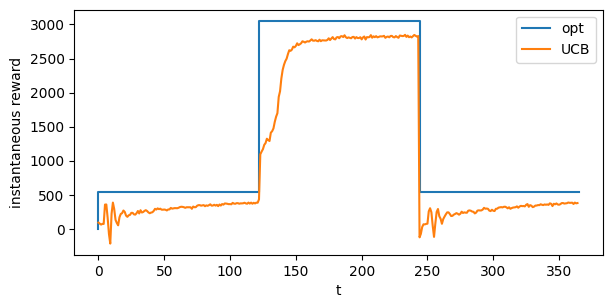

In [93]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.step([0, 122, 244, 365],[0, opt1, opt2, opt3], where='pre', label = "opt")
plt.plot(cusum_ucb_mean_rewards_hat, color = 'C1', label = "UCB")
#plt.fill_between(np.arange(T), sw_ucb_mean_rewards_hat - sw_ucb_std_inst, sw_ucb_mean_rewards_hat + sw_ucb_std_inst, alpha = 0.2, color = 'C1')

plt.legend()

1000
1000


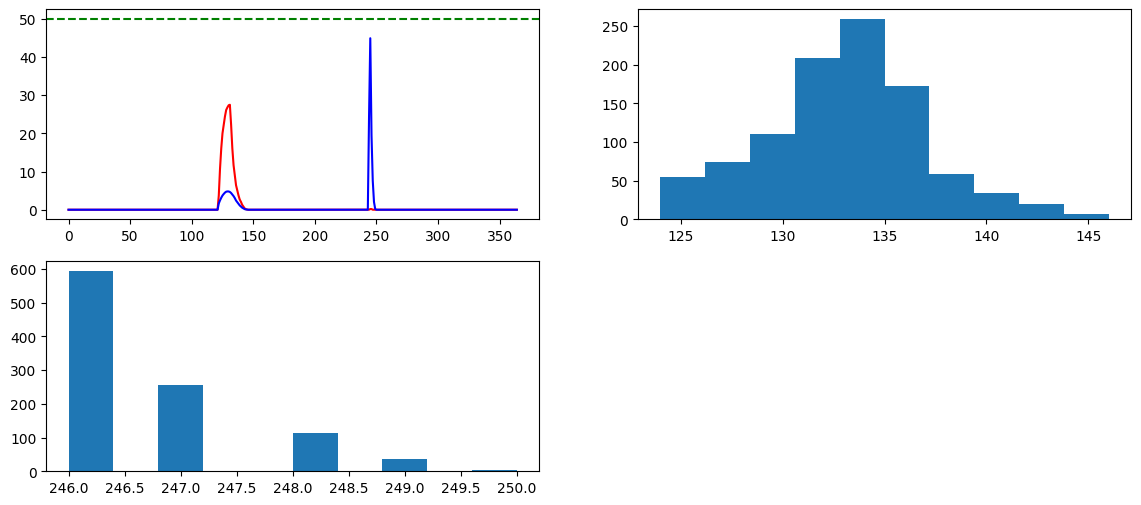

In [95]:
#BUILD CUMSUM CHARTS TO SHOW CHANGE DETECTION

plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.plot(cusum_ucb_mean_gpchart, color = 'r')
plt.plot(cusum_ucb_mean_gmchart, color = 'b')
plt.axhline(y = cusum_ucb_learner.conversion_rate_learner.h , color = 'g', linestyle = 'dashed')


plt.subplot(2,2,2)
plt.hist(p_detections)
print(len(p_detections))


plt.subplot(2,2,3)
plt.hist(m_detections)
print(len(m_detections))

